In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

# Use Low Rank completion from pylop and pyproximal 
import pylops
import pyproximal 

2024-07-22 14:13:39.040502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_10_1000_40.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)

In [3]:
template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list']
label_list = dataset_list[0]['labels']

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Generate random walk for guessing structures
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

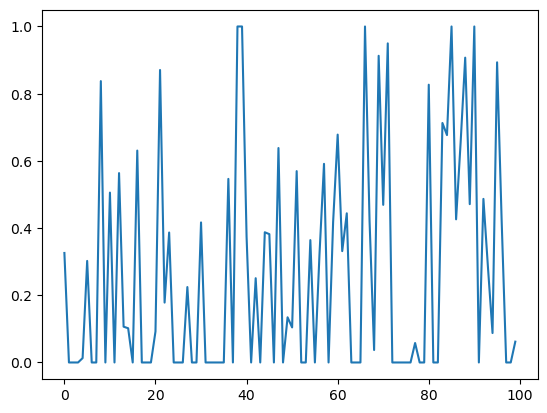

In [4]:
# Introducing missing data to the dataset at specific barcodes with some probabiliity between [0, 1]
missing_data_prob = np.random.normal(0.1, 0.5, num_monomers)
missing_data_prob[missing_data_prob < 0] = 0
missing_data_prob[missing_data_prob > 1] = 1
plt.plot(missing_data_prob)

In [5]:
# Get shuffle indices for shuffling dataset 
shuffle_indices = np.arange(num_observations)
np.random.shuffle(shuffle_indices)

In [6]:
observations_with_nan = np.array([squareform(pdist(x)) for x in X])
observations_with_nan = observations_with_nan[shuffle_indices, :, :]
existing_data = np.zeros(observations_with_nan.shape)
# Randomly add nan to the dataset based on the missing_data_prob
for i in range(num_observations):
    missing_indices = np.random.uniform(size=num_monomers) < missing_data_prob
    observations_with_nan[i, missing_indices, :] = 0
    observations_with_nan[i, :, missing_indices] = 0
    existing_data[i, ~missing_indices, :] = 1
    existing_data[i, :, ~missing_indices] = 1

In [7]:
existing_data_flatten = np.array([x.flatten() for x in existing_data.astype(bool)])

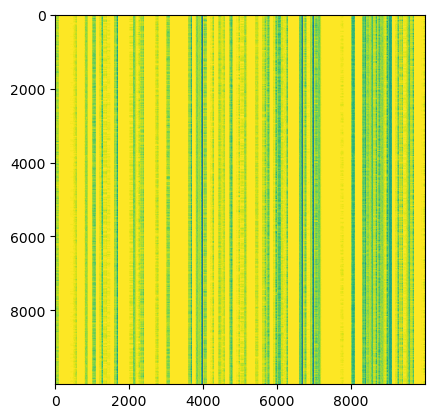

In [8]:
plt.imshow(existing_data_flatten)

In [9]:
observations_flatten = np.array([squareform(pdist(x)) for x in X])[shuffle_indices, :, :]
observations_flatten = np.array([x.flatten() for x in observations_flatten])
observations_flatten_with_nan = np.array([x.flatten() for x in observations_with_nan])

In [56]:
k=1

In [57]:
bc1_nan_map = observations_flatten_with_nan[:, num_probes*k:num_probes*(k+1)]
bc1_map = observations_flatten[:, num_probes*k:num_probes*(k+1)]

In [58]:
# This is the indices of existing data
existing_indices = np.where(existing_data_flatten[:, num_probes*k:num_probes*(k+1)].ravel())

In [12]:
bc1_map[existing_data_flatten[:, :num_probes]] == bc1_nan_map[existing_data_flatten[:, :num_probes]]

array([ True,  True,  True, ...,  True,  True,  True])

In [13]:
bc1_map[0, :]

array([   0.        ,  159.31743928,   77.80900503,  118.89073817,
        250.11108637,  190.15761673,  286.37072641,  247.48663271,
        223.3364939 ,  293.36995223,  286.36385488,  291.49605839,
        246.09983588,  426.41380726,  350.60587481,  363.8000825 ,
        375.64862567,  294.11859262,  419.2535167 ,  380.14023307,
        376.29636217,  463.86161532,  430.84612625,  397.63522129,
        461.9474527 ,  540.75269869,  512.54286694,  534.82265515,
        575.82789653,  546.73186199,  682.89584161,  680.07480412,
        643.59755623,  706.89258337,  635.26782588,  751.23278115,
        746.0064045 ,  840.72170394,  883.987799  ,  909.25392906,
        914.85497598,  993.93221853,  984.9070039 ,  982.8374111 ,
        923.39943511,  962.72203343, 1029.72194069,  963.46511084,
        979.81009586, 1018.59684539, 1029.32171122, 1088.77799296,
       1101.14375383, 1188.22891188, 1174.87341991, 1183.69213434,
       1228.20353627, 1257.39456143, 1219.53748443, 1256.55183

In [14]:
bc1_nan_map[0, :]

array([   0.        ,  159.31743928,   77.80900503,  118.89073817,
        250.11108637,    0.        ,  286.37072641,  247.48663271,
          0.        ,  293.36995223,  286.36385488,  291.49605839,
          0.        ,    0.        ,  350.60587481,  363.8000825 ,
          0.        ,  294.11859262,  419.2535167 ,  380.14023307,
          0.        ,    0.        ,    0.        ,    0.        ,
        461.9474527 ,  540.75269869,  512.54286694,  534.82265515,
        575.82789653,  546.73186199,    0.        ,  680.07480412,
        643.59755623,  706.89258337,  635.26782588,  751.23278115,
        746.0064045 ,  840.72170394,    0.        ,    0.        ,
          0.        ,  993.93221853,    0.        ,  982.8374111 ,
        923.39943511,    0.        , 1029.72194069,  963.46511084,
        979.81009586,    0.        , 1029.32171122,    0.        ,
       1101.14375383, 1188.22891188, 1174.87341991, 1183.69213434,
          0.        , 1257.39456143, 1219.53748443,    0.     

In [59]:
nx, ny = bc1_map.shape
Rop = pylops.Restriction(ny*nx, 
                         existing_indices[0], dtype='float64')

In [60]:
Ux, Sx, Vhx = np.linalg.svd(bc1_map, full_matrices=False)
Uy, Sy, Vhy = np.linalg.svd(bc1_nan_map, full_matrices=False)

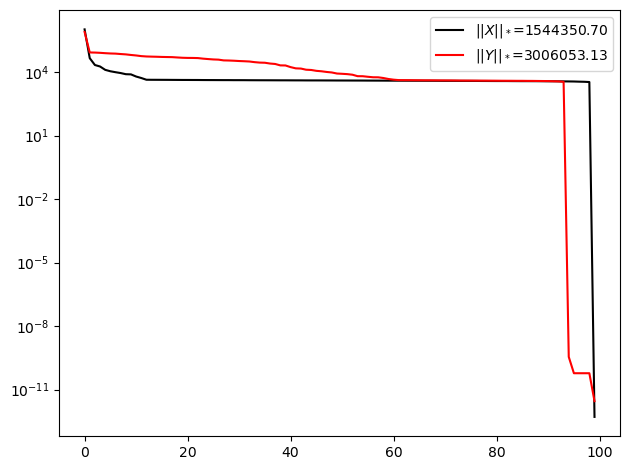

In [61]:
plt.figure()
plt.semilogy(Sx, 'k', label=r'$||X||_*$=%.2f' % np.sum(Sx))
plt.semilogy(Sy, 'r', label=r'$||Y||_*$=%.2f' % np.sum(Sy))
plt.legend()
plt.tight_layout()

In [53]:
Rop.H * Rop * bc1_map.ravel() == bc1_nan_map.ravel()

array([ True,  True,  True, ...,  True,  True,  True])

In [19]:
Rop.H * Rop * bc1_map.ravel()

array([   0.        ,  159.31743928,   77.80900503, ..., 1984.92023593,
       2070.1329332 , 2075.51516452])

In [20]:
bc1_nan_map.ravel()

array([   0.        ,  159.31743928,   77.80900503, ..., 1984.92023593,
       2070.1329332 , 2075.51516452])

In [21]:
(Rop.H * Rop * bc1_map.ravel()).shape

(1000000,)

In [22]:
bc1_nan_map.ravel().shape

(1000000,)

In [63]:
y = Rop * bc1_map.ravel()

In [64]:
mu = .8
f = pyproximal.L2(Rop, y)
g = pyproximal.Nuclear((ny, nx), mu)

Xpg = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                      tau=1., niter=100, show=True)
Xpg = Xpg.reshape(ny, nx)

# Recompute SVD and see how the singular values look like
Upg, Spg, Vhpg = np.linalg.svd(Xpg, full_matrices=False)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 100
niterback = 100	acceleration = vandenberghe

   Itn       x[0]          f           g       J=f+eps*g       tau


KeyboardInterrupt: 

In [78]:
mu1 = 0.8 * np.sum(Sx)
g = pyproximal.proximal.NuclearBall((ny, nx), mu1)

Xpgc = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                       tau=1., niter=100, show=True)
Xpgc = Xpgc.reshape(nx, ny)

# Recompute SVD and see how the singular values look like
Upgc, Spgc, Vhpgc = np.linalg.svd(Xpgc, full_matrices=False)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.NuclearBall'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 100
niterback = 100	acceleration = vandenberghe

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   1.00294e+02   6.152e+09   0.000e+00   6.152e+09   1.000e+00
     2   1.00294e+02   6.152e+09   0.000e+00   6.152e+09   1.000e+00
     3   1.00294e+02   6.152e+09   0.000e+00   6.152e+09   1.000e+00
     4   1.00294e+02   6.152e+09   0.000e+00   6.152e+09   1.000e+00
     5   1.00294e+02   6.152e+09   0.000e+00   6.152e+09   1.000e+00
     6   1.00294e+02   6.152e+09   0.000e+00   6.152e+09   1.000e+00
     7   1.00294e+02   6.152e+09   0.000e+00   6.152e+09   1.000e+00
     8   1.00294e+02   6.152e+09   0.000e+00   6.152e+09   1.000e+00
     9   1.00294e+02   6.152e+09   0.000e+00   6.152e+09   1.000e

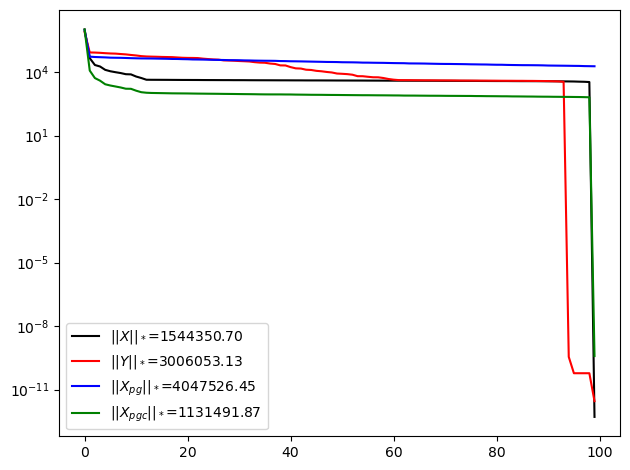

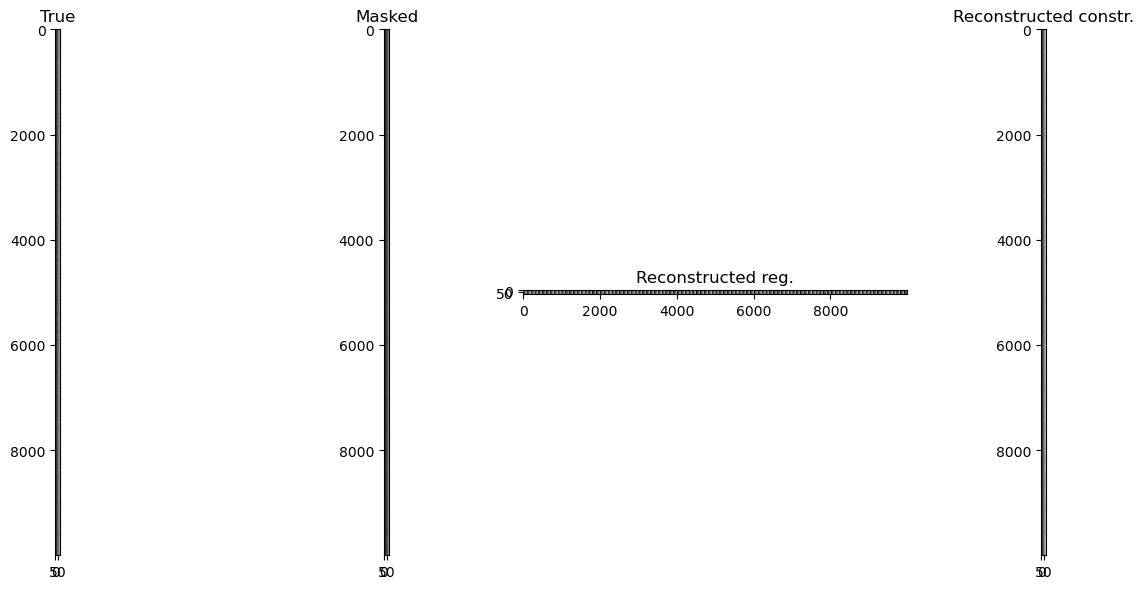

In [79]:
plt.figure()
plt.semilogy(Sx, 'k', label=r'$||X||_*$=%.2f' % np.sum(Sx))
plt.semilogy(Sy, 'r', label=r'$||Y||_*$=%.2f' % np.sum(Sy))
plt.semilogy(Spg, 'b', label=r'$||X_{pg}||_*$=%.2f' % np.sum(Spg))
plt.semilogy(Spgc, 'g', label=r'$||X_{pgc}||_*$=%.2f' % np.sum(Spgc))
plt.legend()
plt.tight_layout()

fig, axs = plt.subplots(1, 4, figsize=(14, 6))
axs[0].imshow(bc1_map, cmap='gray')
axs[0].set_title('True')
axs[1].imshow(bc1_nan_map, cmap='gray')
axs[1].set_title('Masked')
axs[2].imshow(Xpg, cmap='gray')
axs[2].set_title('Reconstructed reg.')
axs[3].imshow(Xpgc, cmap='gray')
axs[3].set_title('Reconstructed constr.')
fig.tight_layout()

In [71]:
np.linalg.norm(bc1_map - bc1_nan_map)

604945.7865084884

In [72]:
np.linalg.norm(bc1_map - Xpg.T)

786919.1717097388

In [73]:
np.linalg.norm(bc1_map - Xpgc.T)

743485.521881238

In [74]:
Xpgc.shape

(100, 10000)

In [75]:
def mean_inputation(nan_2d_array):
    result = nan_2d_array.copy()
    for i in range(nan_2d_array.shape[0]):
        nan_indices = []
        for z, x in enumerate(nan_2d_array[i, :]):
            if x == 0 and z > 0:
                nan_indices.append(z)
            else:
                if not nan_indices:
                    prev_exist = x
                else:
                    diff = (x - prev_exist) / (len(nan_indices)+1)
                    for k, j in enumerate(nan_indices):
                        result[i, j] = prev_exist + diff*(k+1)
                    prev_exist = x
                    nan_indices = []
    return result

In [76]:
X_mi = mean_inputation(bc1_nan_map)

In [77]:
np.linalg.norm(bc1_map-X_mi)

52114.03687109781